In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import time

In [34]:
import pandas as pd

url = 'https://www.tourism.jp/tourism-database/stats/inbound/'
tables = pd.read_html(url)

# 何個のテーブルが見つかったか確認
print(f"見つかったテーブルの数: {len(tables)}")

# 最初のテーブルの中身を少しだけ表示
print(tables[0].head())

見つかったテーブルの数: 1
  国・地域名  月別訪日客数  2025年11月  対前年同月比
0    韓国     NaN  824,500人     NaN
1    中国     NaN  562,600人     NaN
2    台湾     NaN  542,400人     NaN
3    香港     NaN  207,600人     NaN
4    タイ     NaN  117,400人     NaN


In [ ]:
import pandas as pd
import time
import sqlite3

# ターゲットURL
url = 'https://www.tourism.jp/tourism-database/stats/inbound/'

# スクレイピング
tables = pd.read_html(url)
time.sleep(1)  

# データの整理
df = tables[0]

# データベース(SQLite)へ保存
conn = sqlite3.connect('travel_data.db')
df.to_sql('inbound_stats', conn, if_exists='replace', index=False)
conn.close()

print("データの取得とDB保存が完了しました。")

データの取得とDB保存が完了しました。


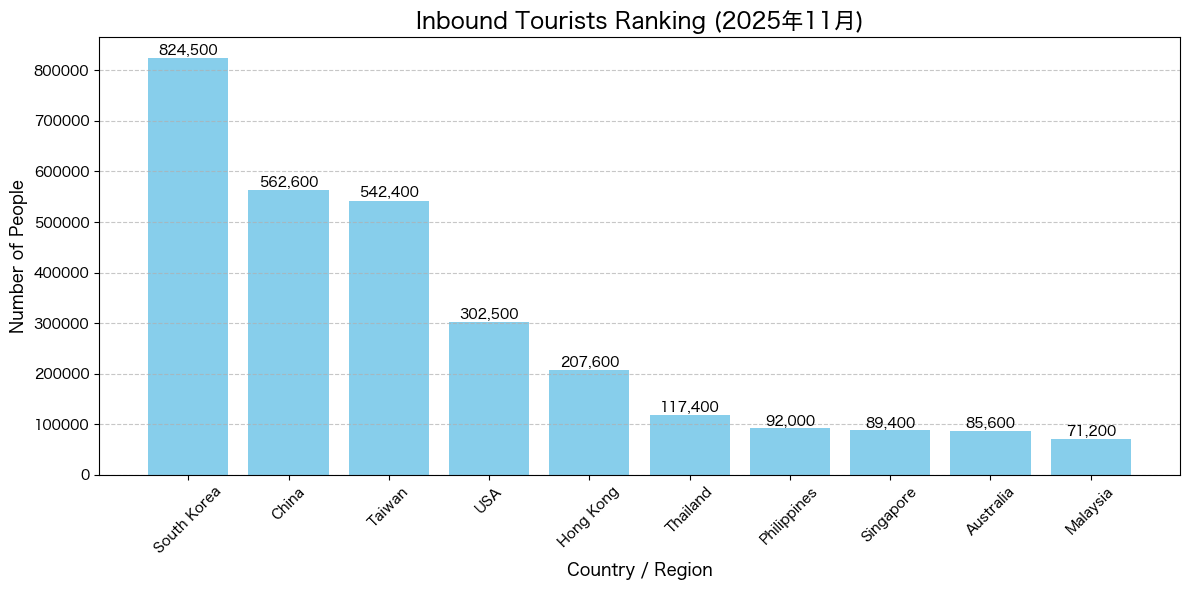

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import re

#  データのクリーニング関数
def clean_numeric(x):
    """Convert strings like '824,500人' to integers"""
    if isinstance(x, str):
        num = re.sub(r'[^-0-9]', '', x)
        return int(num) if num else 0
    return x

# 分析用クラス
class InboundAnalyzer:
    def __init__(self, db_path):
        self.db_path = db_path
        
    def get_data(self):
        """Fetch data from DB using a query (Assignment requirement)"""
        conn = sqlite3.connect(self.db_path)
        df = pd.read_sql("SELECT * FROM inbound_stats", conn)
        conn.close()

        df.columns = [str(c).replace("'", "").replace("(", "").replace(")", "").strip() for c in df.columns]
        
        for col in df.columns:
            if '国・地域' in col:
                df = df.rename(columns={col: 'Country_Region'})
                break
        return df

    def translate_to_english(self, df):
        """Translate Japanese country names to English for better visualization"""
        mapping = {
            '韓国': 'South Korea', '中国': 'China', '台湾': 'Taiwan', 
            '香港': 'Hong Kong', 'タイ': 'Thailand', 'シンガポール': 'Singapore',
            'マレーシア': 'Malaysia', 'インドネシア': 'Indonesia', 'フィリピン': 'Philippines',
            'ベトナム': 'Vietnam', 'インド': 'India', '英国': 'UK', 
            'フランス': 'France', 'ドイツ': 'Germany', 'イタリア': 'Italy',
            'ロシア': 'Russia', 'スペイン': 'Spain', 'USA': 'USA', 
            'カナダ': 'Canada', 'オーストラリア': 'Australia'
        }
        df['Country_Region'] = df['Country_Region'].map(mapping).fillna(df['Country_Region'])
        return df

    def run_analysis(self, limit=10):
        """Dynamic analysis based on input (Assignment requirement)"""
        df = self.get_data()
        df = self.translate_to_english(df)
        
        target_col = df.columns[2]
        df[target_col] = df[target_col].apply(clean_numeric)

        plot_df = df[~df['Country_Region'].str.contains('総数|総計|合計|Total', na=False)]
        plot_df = plot_df.sort_values(by=target_col, ascending=False).head(limit)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(plot_df['Country_Region'], plot_df[target_col], color='skyblue')
        
        plt.title(f"Inbound Tourists Ranking ({target_col})", fontsize=16)
        plt.xlabel("Country / Region", fontsize=12)
        plt.ylabel("Number of People", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}', va='bottom', ha='center')

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    analyzer = InboundAnalyzer('travel_data.db')
    analyzer.run_analysis(limit=10)